In [124]:
import pandas as pd
import nltk
from textblob import TextBlob
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam




In [ ]:
nltk.download('averaged_perceptron_tagger')

In [7]:
def calculate_metrics(df):
    """
    Calculates the average sentence length, average grammatical complexity, and average sentiment
    score for each row of text in the input DataFrame.
    
    Parameters:
        df (Pandas DataFrame): A DataFrame with a single column of text
    
    Returns:
        Pandas DataFrame: A new DataFrame with the columns 'average_sentence_length', 'average_grammatical_complexity',
        and 'average_sentiment'
    """
    # Define a function to calculate the POS tag count for a given sentence
    def pos_tag_count(sentence):
        pos_tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        tag_count = len(pos_tags)
        return tag_count
    
    # Define a function to calculate the sentiment score for a given sentence
    def sentiment_score(sentence):
        blob = TextBlob(sentence)
        score = blob.sentiment.polarity
        return score
    
    # Tokenize the text into sentences
    sentences = df['prompt'].apply(nltk.sent_tokenize)
    
    # Calculate the average sentence length for each row
    df['average_sentence_length'] = sentences.apply(lambda x: sum(len(sentence.split()) for sentence in x)/len(x))
    
    # Calculate the average POS tag count for each row
    df['average_grammatical_complexity'] = sentences.apply(lambda x: sum(pos_tag_count(sentence) for sentence in x)/len(x))
    
    # Calculate the average sentiment score for each row
    df['average_sentiment'] = sentences.apply(lambda x: sum(sentiment_score(sentence) for sentence in x)/len(x))
    
    # Drop the 'sentences' column
    #df = df.drop('sentences', axis=1)
    
    return df[['average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aaronweiss/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
df2 = pd.read_excel("3class.xlsx")
df2

In [9]:
# Calculate the metrics
metrics_df2 = calculate_metrics(df2)
df2

print(list(df2.columns))

['prompt', 'completion', 'average_sentence_length', 'average_grammatical_complexity', 'average_sentiment']


In [127]:
df = pd.read_excel("human_ai.xlsx")

In [128]:
metrics_df = calculate_metrics(df)
df

,prompt,completion,average_sentence_length,average_grammatical_complexity,average_sentiment
0,\n\nThe NBA is home to some of the most amazin...,ai,17.975610,20.878049,0.180748
1,Evelyn McHale’s Most Beautiful Suicide\n\nA ph...,human,16.428571,18.968254,0.107971
2,\n\nIn a world where technology has become an ...,ai,19.000000,21.638889,0.184185
3,An Analysis of the Role of Media Coverage of t...,human,39.333333,43.166667,-0.009496
4,\n\nThe Familial Blackmail Of A Popular Senato...,ai,16.292683,18.097561,0.072050
...,...,...,...,...,...
445,"\n\nIn today's ever-evolving world, communicat...",ai,20.485714,23.685714,0.084739
446,\n\nThe study of Anglo-Saxon culture and histo...,ai,23.457143,25.971429,0.093564
447,\n\nA Vacation to Mars: The Biggest Scam in Mo...,ai,21.029412,23.235294,0.024079
448,\n\nThe Winter Goddess\n\nWinter is one of the...,ai,19.828571,22.028571,0.081576


## all ai text model, 6th, 10th, college

In [19]:
# Load the data from the CSV file
# data = pd.read_csv("path/to/csv")
data = df2.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Encode the labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["completion"])
test_labels = label_encoder.transform(test_data["completion"])

# Convert the data to numpy arrays
train_prompt = np.array(train_data["prompt"])
train_numerical = np.array(train_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])
test_prompt = np.array(test_data["prompt"])
test_numerical = np.array(test_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])


In [20]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_prompt)
train_sequences = tokenizer.texts_to_sequences(train_prompt)
test_sequences = tokenizer.texts_to_sequences(test_prompt)

# Pad the sequences to be the same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")


In [121]:

# Define the inputs for the model
input_text = Input(shape=(max_length,))
input_numerical = Input(shape=(3,))

# Embed the text data
embedding = Embedding(input_dim=10000, output_dim=128)(input_text)
lstm1 = LSTM(32, kernel_regularizer=regularizers.l1(0.01))(embedding)
lstm2 = LSTM(16)(embedding)

# Combine the text
combined = Concatenate()([lstm1, input_numerical])

# Add some dropout for regularization
dropout = Dropout(0.2)(combined)

# Add a dense output layer
output = Dense(len(label_encoder.classes_), activation="softmax")(dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)


In [90]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

In [138]:
learning_rate = 0.001
batch_size = 32

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit([train_padded, train_numerical], train_labels, validation_data=([test_padded, test_numerical], test_labels), epochs=500, batch_size=batch_size, callbacks=[tensorboard_callback])


2023-04-14 11:50:25.575249: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-14 11:50:25.575280: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-14 11:50:25.575931: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/500


2023-04-14 11:50:26.140954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:50:26.597852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:50:27.294963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 1/12 [=>............................] - ETA: 29s - loss: 0.6459 - accuracy: 0.6562

2023-04-14 11:50:28.343456: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-14 11:50:28.343470: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


 3/12 [======>.......................] - ETA: 2s - loss: 0.8066 - accuracy: 0.6875

2023-04-14 11:50:28.626936: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-14 11:50:28.627909: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-14 11:50:28.629060: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230414-115025/train/plugins/profile/2023_04_14_11_50_28
2023-04-14 11:50:28.629740: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20230414-115025/train/plugins/profile/2023_04_14_11_50_28/Aarons-MacBook-Pro.local.trace.json.gz
2023-04-14 11:50:28.630749: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230414-115025/train/plugins/profile/2023_04_14_11_50_28
2023-04-14 11:50:28.631027: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/20230414-115025/train/plugins/profile/2023_04_14_

12/12 [==============================] - ETA: 0s - loss: 0.7236 - accuracy: 0.6694

2023-04-14 11:50:31.019401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:50:31.205166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 7s 378ms/step - loss: 0.7236 - accuracy: 0.6694 - val_loss: 0.6008 - val_accuracy: 0.7556
Epoch 2/500
12/12 [==============================] - 1s 100ms/step - loss: 0.7148 - accuracy: 0.6694 - val_loss: 0.6173 - val_accuracy: 0.7333
Epoch 3/500
12/12 [==============================] - 1s 75ms/step - loss: 0.6820 - accuracy: 0.6750 - val_loss: 0.6188 - val_accuracy: 0.7444
Epoch 4/500
12/12 [==============================] - 1s 86ms/step - loss: 0.6257 - accuracy: 0.6750 - val_loss: 0.6028 - val_accuracy: 0.7222
Epoch 5/500
12/12 [==============================] - 1s 71ms/step - loss: 0.6711 - accuracy: 0.6472 - val_loss: 0.6194 - val_accuracy: 0.7556
Epoch 6/500
12/12 [==============================] - 1s 67ms/step - loss: 0.6202 - accuracy: 0.6722 - val_loss: 0.6118 - val_accuracy: 0.7111
Epoch 7/500
12/12 [==============================] - 1s 79ms/step - loss: 0.8780 - accuracy: 0.5889 - val_loss: 1.5158 - val_accuracy: 0.3556
Epoch 8/500
12/1

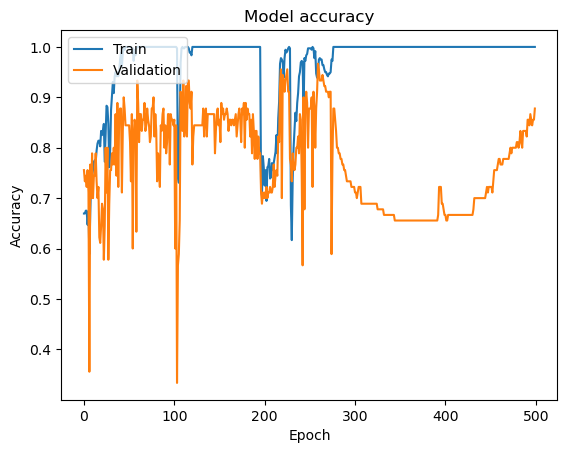

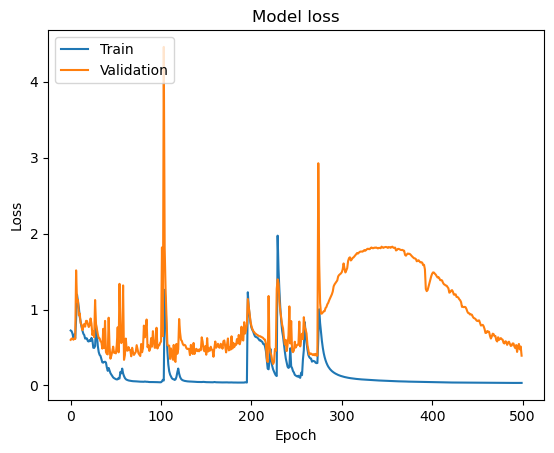

In [139]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [140]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)


2023-04-14 12:13:00.979915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 12:13:01.653323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Training confusion matrix:
[[238   0]
 [  0 122]]
Test confusion matrix:
[[52 10]
 [ 1 27]]


In [23]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate([test_padded, test_numerical], test_labels)

# Print the testing accuracy
print("Test accuracy:", test_acc)


2/2 [==============================] - 0s 29ms/step - loss: 1.1928 - accuracy: 0.2500
Test accuracy: 0.25


## human vs ai

In [131]:
# Load the data from the CSV file
# data = pd.read_csv("path/to/csv")
data = df.copy()

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Encode the labels as integers
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data["completion"])
test_labels = label_encoder.transform(test_data["completion"])

# Convert the data to numpy arrays
train_prompt = np.array(train_data["prompt"])
train_numerical = np.array(train_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])
test_prompt = np.array(test_data["prompt"])
test_numerical = np.array(test_data[["average_sentence_length", "average_grammatical_complexity", "average_sentiment"]])

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_prompt)
train_sequences = tokenizer.texts_to_sequences(train_prompt)
test_sequences = tokenizer.texts_to_sequences(test_prompt)

# Pad the sequences to be the same length
max_length = 100
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

# Define the inputs for the model
input_text = Input(shape=(max_length,))
input_numerical = Input(shape=(3,))

# Embed the text data
embedding = Embedding(input_dim=10000, output_dim=128)(input_text)
lstm1 = LSTM(64, kernel_regularizer=regularizers.l1(0.01))(embedding)
lstm2 = LSTM(16)(embedding)

# Combine the text
combined = Concatenate()([lstm1, input_numerical])

# Add some dropout for regularization
dropout = Dropout(0.2)(combined)

# Add a dense output layer
output = Dense(len(label_encoder.classes_), activation="softmax")(dropout)

# Define the model
model = Model(inputs=[input_text, input_numerical], outputs=output)

learning_rate = 0.001
batch_size = 32

optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit([train_padded, train_numerical], train_labels, validation_data=([test_padded, test_numerical], test_labels), epochs=500, batch_size=batch_size, callbacks=[tensorboard_callback])


2023-04-14 11:26:36.235144: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-14 11:26:36.235154: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-14 11:26:36.235209: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Epoch 1/500


2023-04-14 11:26:36.703695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:26:37.081341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:26:37.745152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 2/12 [====>.........................] - ETA: 2s - loss: 21.3436 - accuracy: 0.5781 

2023-04-14 11:26:38.744650: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-14 11:26:38.744669: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-14 11:26:38.961194: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-14 11:26:38.962086: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-14 11:26:38.963251: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230414-112636/train/plugins/profile/2023_04_14_11_26_38
2023-04-14 11:26:38.964009: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20230414-112636/train/plugins/profile/2023_04_14_11_26_38/Aarons-MacBook-Pro.local.trace.json.gz
2023-04-14 11:26:38.965070: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20230414-112636/train/plugins

12/12 [==============================] - ETA: 0s - loss: 19.6946 - accuracy: 0.6222

2023-04-14 11:26:41.760635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-14 11:26:41.883613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 7s 378ms/step - loss: 19.6946 - accuracy: 0.6222 - val_loss: 17.4148 - val_accuracy: 0.6889
Epoch 2/500
12/12 [==============================] - 1s 84ms/step - loss: 16.1743 - accuracy: 0.6472 - val_loss: 14.0781 - val_accuracy: 0.6889
Epoch 3/500
12/12 [==============================] - 1s 66ms/step - loss: 12.8997 - accuracy: 0.6472 - val_loss: 10.9241 - val_accuracy: 0.7667
Epoch 4/500
12/12 [==============================] - 1s 84ms/step - loss: 9.5355 - accuracy: 0.9639 - val_loss: 8.2208 - val_accuracy: 0.9111
Epoch 5/500
12/12 [==============================] - 2s 112ms/step - loss: 7.2146 - accuracy: 0.9333 - val_loss: 6.0141 - val_accuracy: 0.9333
Epoch 6/500
12/12 [==============================] - 1s 73ms/step - loss: 5.2400 - accuracy: 0.8944 - val_loss: 4.2676 - val_accuracy: 0.8778
Epoch 7/500
12/12 [==============================] - 1s 76ms/step - loss: 3.6732 - accuracy: 0.8667 - val_loss: 2.7917 - val_accuracy: 0.8778
Epoch 8/50

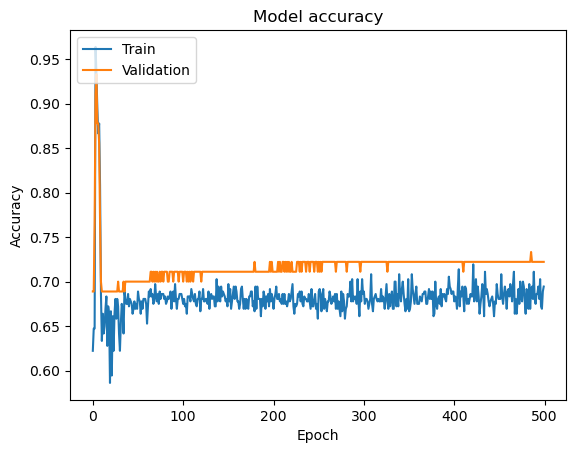

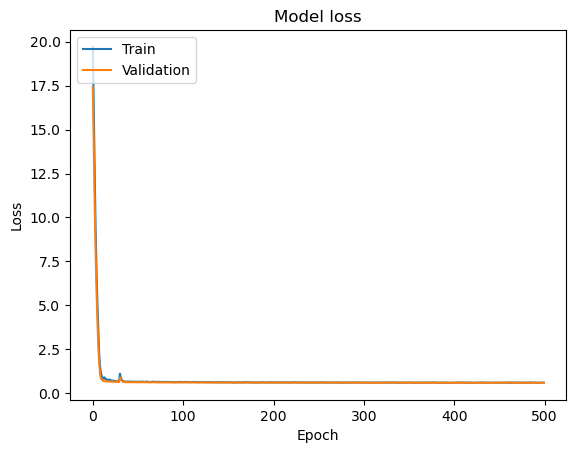

In [132]:
import matplotlib.pyplot as plt

# Plot the training and validation accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

# Plot the training and validation loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Make predictions on the training set
train_pred = model.predict([train_padded, train_numerical])
train_pred_classes = np.argmax(train_pred, axis=1)

# Create the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, train_pred_classes)

print("Training confusion matrix:")
print(train_cm)

# Make predictions on the test set
test_pred = model.predict([test_padded, test_numerical])
test_pred_classes = np.argmax(test_pred, axis=1)

# Create the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, test_pred_classes)

print("Test confusion matrix:")
print(test_cm)


Training confusion matrix:
[[225  13]
 [104  18]]
Test confusion matrix:
[[62  0]
 [25  3]]
